## 互联网寒冬下，数据分析师还吃香吗？
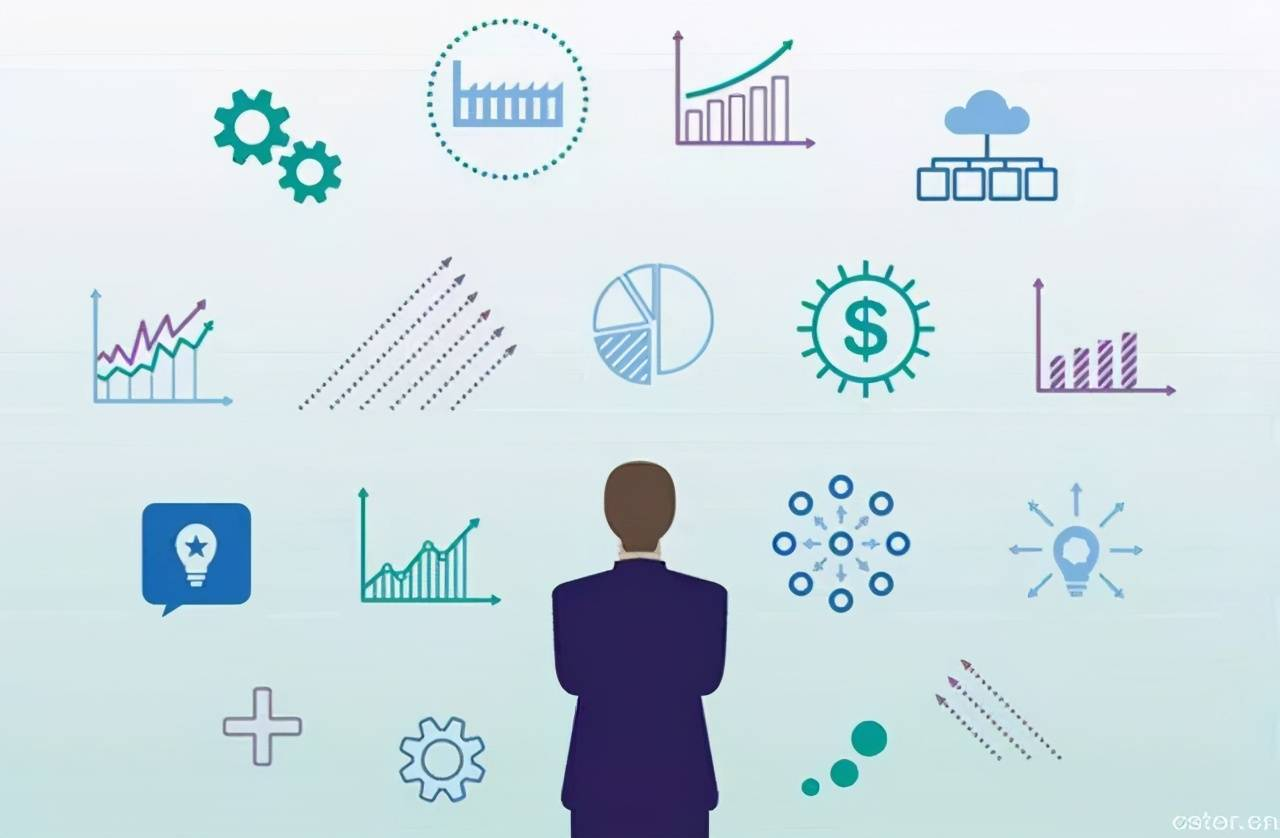

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyecharts.charts import Pie
from pyecharts import options as opts
import matplotlib.pyplot as plt
import re
from PIL import Image
import wordcloud
import jieba
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})
pd.set_option("display.max_column", None)
pd.set_option("display.max_row",None)
%matplotlib inline

In [29]:
path='F:\\python-数据分析师分析\\lagou.csv'
df=pd.read_csv(path,sep=",")
#df.head()

In [30]:
#取出我们后续数据分析需要的字段
df.columns
columns = ["positionName", "companyShortName", "city", "companySize", "education", "financeStage",
           "industryField", "salary", "workYear", "hitags", "companyLabelList", "job_detail"]
df=df[columns].drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2939 entries, 0 to 3139
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   positionName      2939 non-null   object
 1   companyShortName  2939 non-null   object
 2   city              2939 non-null   object
 3   companySize       2939 non-null   object
 4   education         2939 non-null   object
 5   financeStage      2939 non-null   object
 6   industryField     2939 non-null   object
 7   salary            2939 non-null   object
 8   workYear          2939 non-null   object
 9   hitags            240 non-null    object
 10  companyLabelList  2939 non-null   object
 11  job_detail        1401 non-null   object
dtypes: object(12)
memory usage: 298.5+ KB


## 番外话
### 数据分析黄金5步法：
    1. 提出问题(需要解决的问题)
    2. 假设问题
    3. 数据收集
    4. 数据清洗及可视化
    5. 结论

## 分析目标
- 1.各城市对数据分析岗位的需求情况
- 2.不同细分领域对数据分析岗的需求情况
- 3.数据分析岗位的薪资状况
- 4.工作经验与薪资的关系
- 5.公司都要求掌握什么技能
- 6.数据分析岗位的学历要求高吗
- 7.不同规模的企业对工作经验的要求以及提供的薪资水平
- 8.一线城市薪资分布图
- 9.各公司提供的福利待遇情况

## 数据清洗

### 1.去掉非数据岗位的信息(包含数据分析且不包含实习生)

In [31]:
df.head(1)

,positionName,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail
0,数据分析岗,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据..."


In [32]:
cou1=df['positionName'].str.contains('数据分析')
#print(cou1)
cou2=~df['positionName'].str.contains('实习')
#cou2
df=df.loc[cou1&cou2]
df.shape

(1326, 12)

In [33]:
#删除'positionName'多余字段
df.drop('positionName',axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()


,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据..."
1,音娱时光,北京,50-150人,本科,A轮,移动互联网,10k-18k,1-3年,NaN,"['年底双薪', '绩效奖金', '带薪年假', '免费健身']",职责描述：||1. 完善业务数据监控体系，进行新功能指标埋点逻辑设计，搭建分析框架，...
2,千喜鹤,北京,2000人以上,本科,未融资,消费生活,20k-30k,3-5年,NaN,[],工作职责：||1.负责根据业务目标，制定并执行产品或业务的运营数据监控与分析机制。||2.完...
3,吉林省海生电子商务有限公司,北京,少于15人,本科,不需要融资,电商,33k-50k,3-5年,NaN,[],1.基于对业务的支持和理解，搭建出可以准确反映业务运作状况的数据指标体系；||2.商业嗅觉灵...
4,WPIC,北京,50-150人,本科,未融资,"电商,软件开发",10k-15k,1-3年,NaN,[],职责描述：||1. 调研工作以客户需求为主导；||2. 根据市场调研计划，进行市场信息的收集...


### 2.将拉勾网的薪水转化为数值(薪资含K和k，取均值作为工资水平)

In [34]:
def avg(x):
    a=re.findall('[0-9]+[\.[0-9]+]?|[0-9]+',x)
    if len(a)==1:
        avg=float(a)
    else:
        avg=(float(a[0])+float(a[1]))/2
    return avg
df['avgsalary']=df['salary'].apply(avg)
df.head(1)
        

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,avgsalary
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",22.5


### 3.从job_detail中提取出技能要求
#### 将技能分为以下几类：
- Python/R
- SQL
- Tableau
- Excel
- #### 如果job_detail中含有上述四类，则赋值为1，不含有则为0

In [35]:
df['job_detail']=df['job_detail'].str.lower().fillna('')#把所有字母变小写再将空行换为空字符串
df['Python/R']=df['job_detail'].apply(lambda x : 1 if ('python' in x or 'r' in x) else 0 )#此处if后或必须要分开写
df['SQL']=df['job_detail'].apply(lambda x : 1 if ('sql' in x or 'hive' in x) else 0 )
df['Tableau']=df['job_detail'].apply(lambda x : 1 if ('tableau' in x) else 0 )
df['Excel']=df['job_detail'].apply(lambda x : 1 if ('excel' in x) else 0 )


### 4.处理行业信息

In [36]:
df['industryField']=df['industryField'].apply(lambda x: x.split(',')[0])
df.head(1)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,avgsalary,Python/R,SQL,Tableau,Excel
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",22.5,1,1,0,1


## 数据分析

### 1.各城市对数据分析岗位的需求情况

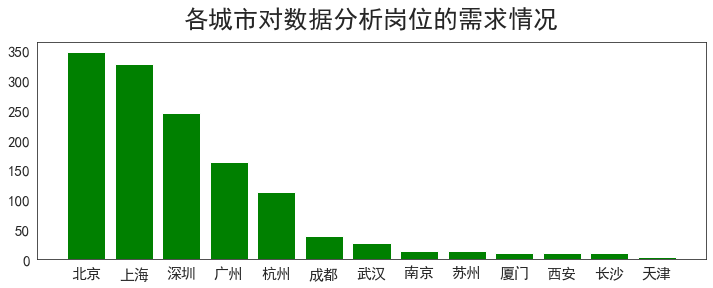

In [37]:
df_city=df.city.value_counts()
index1=df_city.index
ax,fig=plt.subplots(figsize=(12,4))
plt.bar(index1,df_city,color='green')
plt.title('各城市对数据分析岗位的需求情况',fontsize=25,y=1.04)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### 一线城市北京、上海、广州、深圳对分析师需求很大，杭州、成都、武汉等一线城市有一定机会，数据分析师找工作最好还是去大城市。

### 2.不同细分领域对数据分析岗的需求情况(取前十)

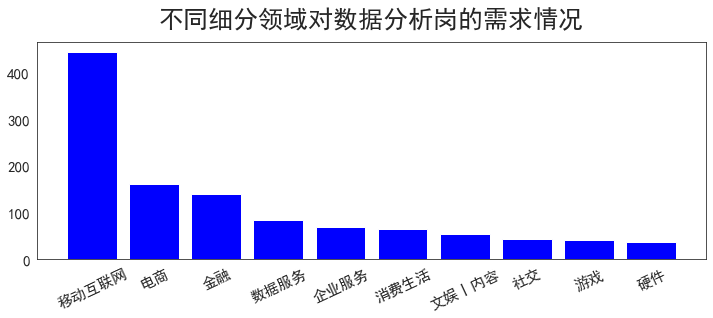

In [38]:
df_ly=df.industryField.value_counts()[:10]
df_ly
index2=df_ly.index
ax,fig=plt.subplots(figsize=(12,4))
plt.bar(index2,df_ly,color="blue")
plt.title('不同细分领域对数据分析岗的需求情况',fontsize=25,y=1.04)
plt.xticks(fontsize=15,rotation=25)#横坐标显示不完全，旋转一定角度
plt.yticks(fontsize=15)
plt.show()

#### 互联网行业、电商、金融对数据分析需求量最大

### 3.数据分析岗位的薪资状况

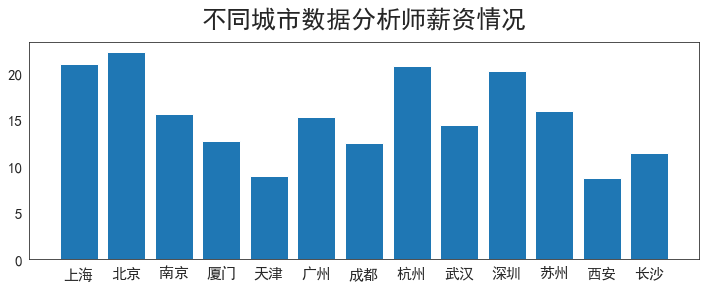

In [39]:
#1.不同城市数据分析师薪资情况
df_avg=df.groupby(['city']).avgsalary.mean()
index3=df_avg.index
ax,fig=plt.subplots(figsize=(12,4))
plt.bar(index3,df_avg)
plt.title('不同城市数据分析师薪资情况',fontsize=25,y=1.04)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### 一线城市北京、上海、深圳薪资均值最高，其次是杭州、苏州、广州（广州的均值低于新一线城市）

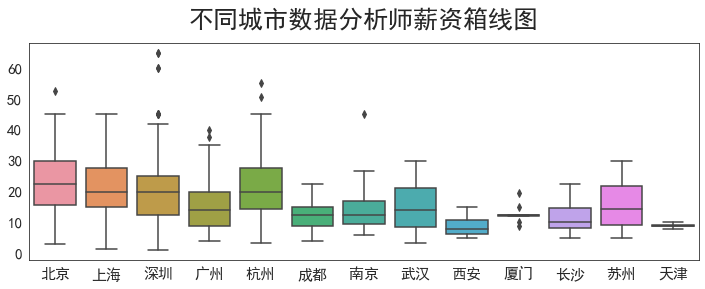

In [40]:
#2.不同城市数据分析师薪资情况
plt.figure(figsize=(12,4))
sns.boxplot(x='city',y='avgsalary',data=df)
plt.title('不同城市数据分析师薪资箱线图',fontsize=25,y=1.04)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 4.工作经验与薪资的关系
#### 不同工作经验，不同城市的薪资

<Figure size 1152x432 with 0 Axes>

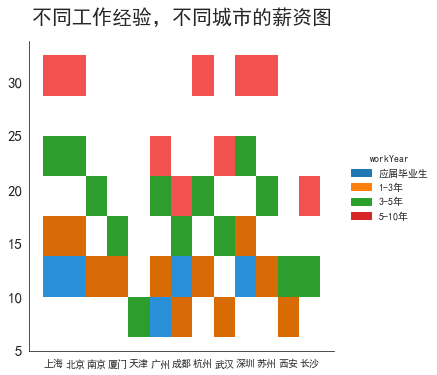

In [41]:
df_age=df.pivot_table(index='city',columns='workYear',values='avgsalary',aggfunc='mean')#数据透视找到每个城市每种经验的均值
df_age.reset_index(inplace=True)#重置索引为下面数据重构做准备
df_age=df_age[['city','应届毕业生','1-3年','3-5年','5-10年']]
df_age.set_index('city',inplace=True)
df_age=df_age.stack().reset_index()
#print(df_age)
plt.figure(figsize=(16,6))
sns.displot(x='city',y=0,hue='workYear',data=df_age)#0为索引不加“”
plt.title('不同工作经验，不同城市的薪资图',fontsize=20,y=1.04)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=15)
plt.show()

#### 5-10年后北京、杭州、深圳、苏州的薪资能达到30k，其他城市没有这个水平（可能是数据不足）

### 5.公司都要求掌握什么技能

In [42]:
df.head(2)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,avgsalary,Python/R,SQL,Tableau,Excel
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",22.5,1,1,0,1
1,音娱时光,北京,50-150人,本科,A轮,移动互联网,10k-18k,1-3年,NaN,"['年底双薪', '绩效奖金', '带薪年假', '免费健身']",职责描述：||1. 完善业务数据监控体系，进行新功能指标埋点逻辑设计，搭建分析框架，...,14.0,1,1,0,1


Python/R    806
其他          298
SQL         153
Excel        67
Tableau       2
Name: skill, dtype: int64


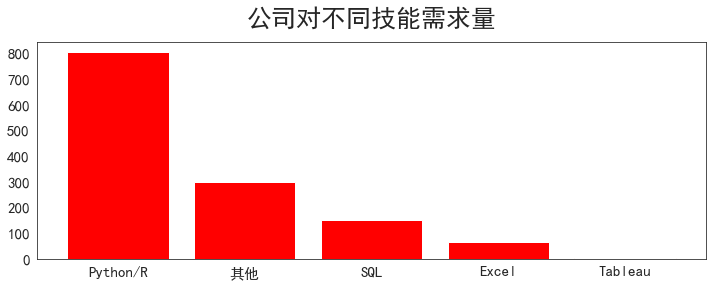

In [43]:
def skill(x):#处理整个数据集，优先级是python，sql，excel
    if x['Python/R']==1:
        x['skill']='Python/R'
    elif x['SQL']==1:
        x['skill']='SQL'
    elif x['Excel']==1:
        x['skill']='Excel'
    elif x['Tableau']==1:
        x['skill']='Tableau'
    else :
        x['skill']='其他' 
    return x
df=df.apply(skill,axis=1)
df_skill=df.skill.value_counts()
print(df_skill)
index5=df_skill.index
ax,fig=plt.subplots(figsize=(12,4))
plt.bar(index5,df_skill,color="red")
plt.title('公司对不同技能需求量',fontsize=25,y=1.04)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

    

#### python的需求量最大其次是SQL和EXCEL，看来真的是人生苦短，我用python

### 6.数据分析岗位的学历要求高吗

本科    1108
大专      84
不限      81
硕士      53
Name: education, dtype: int64


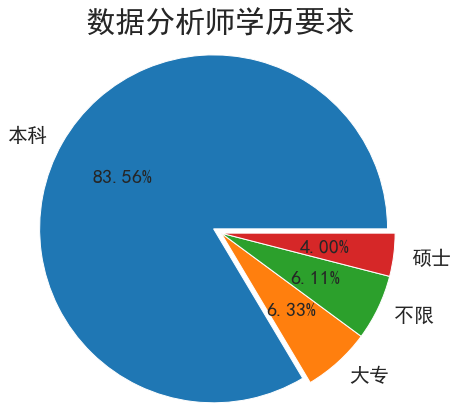

In [44]:
df_edu=df.education.value_counts()
print(df_edu)
index6=df_edu.index
#print(index6)
pie=plt.pie(df_edu,labels=index6,autopct='%0.2f%%',radius=2,explode=[0.1,0,0,0])
for font in pie[1]:
    font.set_size(20)  #[1]设置标签字体大小
for font in pie[2]:
    font.set_size(20)  #[2]设置百分比大小 
plt.title('数据分析师学历要求',fontsize=30,y=1.4)
plt.show()

#### 数据分析师岗位学习普遍要求本科就行，想做数据分析师门槛并不高

### 7.不同规模的企业对工作经验的要求以及提供的薪资水平

In [45]:
df.companySize.unique()

array(['2000人以上', '50-150人', '少于15人', '150-500人', '500-2000人', '15-50人'],
      dtype=object)

In [46]:
#大公司：2000以上；中型公司：500-2000，小公司：500以下

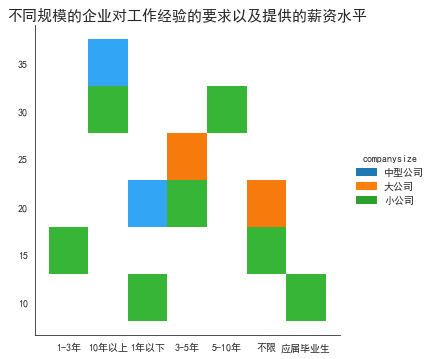

In [47]:
def CS(x):#公司规模
    if x['companySize']=='2000人以上':
        x['companysize']='大公司'
    elif x['companySize']=='500-2000人':
        x['companysize']='中型公司'
    else:
        x['companysize']='小公司'
    return x
df=df.apply(CS,axis=1)#axis=1,
#df
dfx=df.pivot_table(index='companysize',columns='workYear',values='avgsalary',aggfunc='mean') 
dfx=dfx.stack().reset_index()
#print(dfx)  
sns.displot(x='workYear',y=0,hue='companysize',data=dfx)
plt.title('不同规模的企业对工作经验的要求以及提供的薪资水平',fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.show()

### 8.一线城市薪资分布图

In [48]:
df.head(1)

,companyShortName,city,companySize,education,financeStage,industryField,salary,workYear,hitags,companyLabelList,job_detail,avgsalary,Python/R,SQL,Tableau,Excel,skill,companysize
0,达达-京东到家,北京,2000人以上,本科,D轮及以上,消费生活,15k-30k,3-5年,"['免费班车', '新婚红包', '定期调薪', '电脑补贴', '生子红包', '地铁周边...","['年底双薪', '绩效奖金', '岗位晋升', '定期体检']","1 、负责o2o电商日常运营数据的统计, 监控, 梳理指标体系；||2、基于海量用户行为数据...",22.5,1,1,0,1,Python/R,大公司


In [49]:
df_big=df.loc[df.city.isin(['北京','上海','深圳','广州'])]
df_big.city.unique()

array(['北京', '上海', '深圳', '广州'], dtype=object)

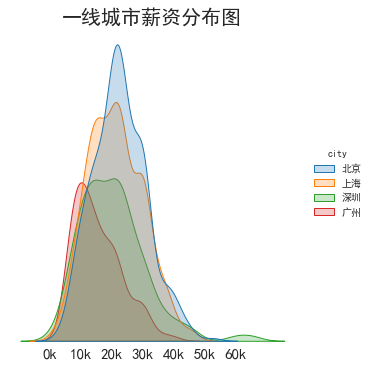

In [50]:
sns.displot(x='avgsalary',hue='city',data=df_big,fill=True,kind='kde')
plt.ylabel('')#y标签空字符串
plt.yticks([])#y刻度为空列表
plt.box('')#去掉框线
plt.title('一线城市薪资分布图',fontsize=20)
plt.xlabel('')
plt.xticks(range(0,70,10),[str(i)+'k'for i in range(0,70,10)],fontsize=15)
plt.show()

#### 北京、上海、深圳普遍集中在20k左右，广州偏低一些10k位置

### 9.各公司提供的福利待遇情况

In [51]:
'''
### 词云图有蒙版
df_fl=df.loc[df.hitags.notnull(),'hitags']#不含空值列表
df_fl=",".join(df_fl)#此处注意用","连接，否则列表连接处会不准
#print(df_fl)
text=df_fl.replace('[','').replace(']','').replace("'",'')
Text=text.split(",")
#print(Text)
ser=pd.Series(Text,name='福利词频')
cou=ser.value_counts().sort_values(ascending=False)[:10]
print(cou)
img = Image.open("mask_pic.jpg") # 打开遮罩图片
mask = np.array(img) #将图片转换为数组
stopwords = [] # 去掉不需要显示的词
#collocations=False,不统计搭配词，不出现重复词。
wc = wordcloud.WordCloud(font_path="msyh.ttc",
                         collocations=False,
                         width = 1000,
                         height = 700,
                         background_color='white',
                         max_words=200,
                         mask=mask,
                         stopwords=stopwords)
# msyh.ttc电脑本地字体，写可以写成绝对路径
wc.generate(text) # 加载词云文本
# 显示词云
plt.imshow(wc, interpolation='bilinear')# 用plt显示图片
plt.axis("off")  # 不显示坐标轴
plt.show() # 显示图片
wc.to_file('f:\\desktop\\fuli词云图.png')
'''

'\n### 词云图有蒙版\ndf_fl=df.loc[df.hitags.notnull(),\'hitags\']#不含空值列表\ndf_fl=",".join(df_fl)#此处注意用","连接，否则列表连接处会不准\n#print(df_fl)\ntext=df_fl.replace(\'[\',\'\').replace(\']\',\'\').replace("\'",\'\')\nText=text.split(",")\n#print(Text)\nser=pd.Series(Text,name=\'福利词频\')\ncou=ser.value_counts().sort_values(ascending=False)[:10]\nprint(cou)\nimg = Image.open("mask_pic.jpg") # 打开遮罩图片\nmask = np.array(img) #将图片转换为数组\nstopwords = [] # 去掉不需要显示的词\n#collocations=False,不统计搭配词，不出现重复词。\nwc = wordcloud.WordCloud(font_path="msyh.ttc",\n                         collocations=False,\n                         width = 1000,\n                         height = 700,\n                         background_color=\'white\',\n                         max_words=200,\n                         mask=mask,\n                         stopwords=stopwords)\n# msyh.ttc电脑本地字体，写可以写成绝对路径\nwc.generate(text) # 加载词云文本\n# 显示词云\nplt.imshow(wc, interpolation=\'bilinear\')# 用plt显示图片\nplt.axis("off")  # 不显示坐标轴\nplt.show() # 显示图片\nwc.t

 免费体检     70
 地铁周边     68
 定期团建     67
 5险1金     61
免费班车      54
 mac办公    45
 学习机会     41
 6险1金     37
 免费下午茶    36
 年轻团队     30
Name: 福利词频, dtype: int64


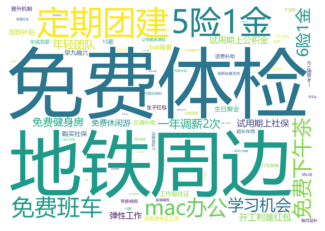

In [52]:
df_fl=df.loc[df.hitags.notnull(),'hitags']#不含空值列表
df_fl=",".join(df_fl)#此处注意用","连接，否则列表连接处会不准
#print(df_fl)
text=df_fl.replace('[','').replace(']','').replace("'",'')
Text=text.split(",")
#print(Text)
ser=pd.Series(Text,name='福利词频')
cou=ser.value_counts().sort_values(ascending=False)[:10]
print(cou)
#img = Image.open("mask_pic.jpg") # 打开遮罩图片
#mask = np.array(img) #将图片转换为数组
stopwords = [] # 去掉不需要显示的词
#collocations=False,不统计搭配词，不出现重复词。
wc = wordcloud.WordCloud(font_path="msyh.ttc",
                         collocations=False,
                         width = 1000,
                         height = 700,
                         background_color='white',
                         max_words=200,
                         stopwords=stopwords)
# msyh.ttc电脑本地字体，写可以写成绝对路径
wc.generate(text) # 加载词云文本
# 显示词云
plt.imshow(wc, interpolation='bilinear')# 用plt显示图片
plt.axis("off")  # 不显示坐标轴
plt.show() # 显示图片
wc.to_file('f:\\desktop\\fuli词云图.png')

#### 数据分析岗位各公司福利标配，免费体检、地铁周边、定期团建（公司对员工的身体健康、心理健康、以及交通的便利很是看重），其次还有五险一金、学习机会等福利

## 分析总结

1. 数据分析师门槛并不高，本科学历即可；想要从事数据分析师，最好精通python,对找工作很有利。
2. 北上广深一线城市对数据分析师需求量很大，杭州武汉成都新一线城市也有一定需求，数据分析师岗位集中在大城市。
3. 北京、上海、深圳普遍集中在20k左右，广州偏低一些10k位置，想要拿高薪去一线城市是好的选择
4. 互联网、电商、金融行业对数据分析师的需求最大，大家认准行业，争取早日实现财务自由
5. 数据分析师的福利待遇还是挺好的，五险一金、免费体检、免费下午茶、交通方面都能照顾到

#### 感谢您的观看，欢迎一起交流，感谢大神易执(知乎名)，公众号：Python读财的无私分享
#### 本报告代码地址：
#### 如有侵权，立删此贴